## Import requirements

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
import glob
import pickle

import sys
sys.path.insert(0, '..')
from ca_funcs import *
from utils import *


%load_ext autoreload
%autoreload 2

c:\users\darek\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Create a new model

In [2]:
from train_ca import *

try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession()

wspan, hspan = 10, 10
layer_dims = [100,100,100,100,100]

test_model = ConvNet(sess, input_dim=(wspan,hspan), layer_dims=layer_dims, weight_scale=1e0)

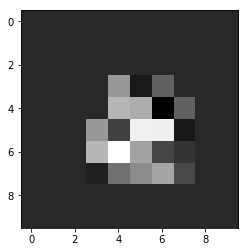

In [7]:
# Run untrained model on test data
X = test_model.X
ca_model = test_model.ca_cnn(X)
out = sess.run(ca_model, feed_dict={X: make_glider((10,10))})

plt.imshow(out)

# Train a new model

In [2]:
from train_ca import *

try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession()

In [3]:
## Make training data
batch_size, wspan, hspan = (100,10,10)

X_train = np.random.choice([0,1], (batch_size, wspan, hspan), p=[.5,.5])
gol = make_game_of_life()
y_train_tf = gol(conv_cast(X_train))
y_train = y_train_tf.eval()



## Define model parameters
layer_dims = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
learning_rate = 0.0001
weight_scale = 1e0
num_batches = 1
training_epochs = 100
batch_size = 10
num_batches = 1
training_epochs = 1500
display_step = int(training_epochs/10)

## Define model
test_model = ConvNet(sess, input_dim=(wspan, hspan), layer_dims=layer_dims, weight_scale=weight_scale)
X, y = test_model.X, test_model.y
ca_model = test_model.ca_cnn(X)

## Define loss and optimizer
loss = tf.reduce_sum(tf.nn.l2_loss(ca_model - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)


## Re-initialize everything, since the optimizer needs to be initialized
init = tf.global_variables_initializer()
sess.run(init)

## Now perform training
all_losses = list()
for epoch in range(training_epochs):

    avg_cost = 0.0
    avg_cost_rounded = 0.0
    
    for i in range(num_batches):
        batch_indices = np.random.choice(range(X_train.shape[0]), batch_size)

        for batch_ind in batch_indices:
            X_batch, y_batch = X_train[batch_ind], y_train[batch_ind]
            _, cost = sess.run([train_op, loss], feed_dict={X: X_batch, y: y_batch})

            avg_cost += cost/(num_batches*batch_size)
    all_losses.append(avg_cost)  
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))

Epoch: 0001 cost=727148.993750000
Epoch: 0151 cost=8.035618973
Epoch: 0301 cost=6.478339553
Epoch: 0451 cost=5.045743346
Epoch: 0601 cost=3.301548845
Epoch: 0751 cost=2.276217663
Epoch: 0901 cost=0.748564085
Epoch: 1051 cost=0.197094048
Epoch: 1201 cost=0.045383141
Epoch: 1351 cost=0.020902108


Text(0.5,1,'Observed Output')

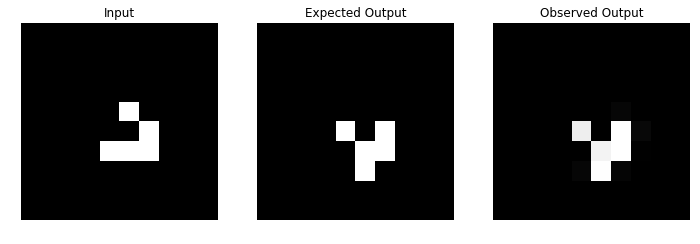

In [4]:
X_test = make_glider(10)

gol = make_game_of_life()
y_test_tf = gol(conv_cast(X_test[np.newaxis,...]))
y_test = np.squeeze(y_test_tf.eval())

y_pred_test = sess.run(ca_model, feed_dict={X: X_test})

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_test)
plt.axis('off')
plt.title("Input")


plt.subplot(1,3,2)
plt.imshow(y_test)
plt.axis('off')
plt.title("Expected Output")

plt.subplot(1,3,3)
plt.imshow(y_pred_test)
plt.axis('off')
plt.title("Observed Output")


In [8]:
## Save the model
saver = tf.train.Saver(max_to_keep=None)
save_str = 'convca/resources/test_model.ckpt'
saver.save(sess, save_str)
print(save_str)

INFO:tensorflow:convca/resources/test_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
convca/resources/test_model.ckpt


# Loading a saved model

In [2]:
from train_ca import *

try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession()

In [3]:
wspan, hspan = 10, 10
model_str = '../resources/test_model.ckpt'


## Define model
test_model = ConvNet(sess, ckpt_path=model_str, input_dim=(wspan,hspan))
X, y = test_model.X, test_model.y
ca_model = test_model.ca_cnn(X)

12.0 layers detected
INFO:tensorflow:Restoring parameters from ../resources/test_model.ckpt


Text(0.5, 1.0, 'Observed Output')

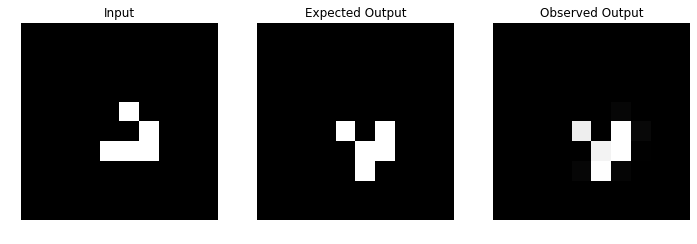

In [4]:
X_test = make_glider(10)

gol = make_game_of_life()
y_test_tf = gol(conv_cast(X_test[np.newaxis,...]))
y_test = np.squeeze(y_test_tf.eval())

y_pred_test = sess.run(ca_model, feed_dict={X: X_test})

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_test)
plt.axis('off')
plt.title("Input")


plt.subplot(1,3,2)
plt.imshow(y_test)
plt.axis('off')
plt.title("Expected Output")

plt.subplot(1,3,3)
plt.imshow(y_pred_test)
plt.axis('off')
plt.title("Observed Output")
